# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.351221
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

because our class number is 10. when every probability is same, it means that probabilty(y) is also roughly 10%.
therefor loss would be something close to value -log(0.1)


In [4]:

a = [1.05348 ,   0.95902936 ,0.95800745, 0.89386195 ,0.78339884 ,1.22661456,
 0.90714429, 0.84470385, 0.97075295, 1.07305218]
print(sum(a))
1/sum(a)

9.67004543


0.10341213050536827

In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.295039 analytic: -0.295039, relative error: 1.466976e-07
numerical: 1.084042 analytic: 1.084042, relative error: 7.245837e-09
numerical: 2.816389 analytic: 2.816389, relative error: 4.849984e-09
numerical: -1.037029 analytic: -1.037029, relative error: 6.973696e-08
numerical: -0.646545 analytic: -0.646545, relative error: 1.984852e-08
numerical: 4.207386 analytic: 4.207386, relative error: 9.254249e-09
numerical: -1.291257 analytic: -1.291257, relative error: 3.583125e-09
numerical: -2.267292 analytic: -2.267292, relative error: 3.578032e-09
numerical: -0.721701 analytic: -0.721701, relative error: 3.927232e-08
numerical: -4.240642 analytic: -4.240642, relative error: 6.458598e-09
numerical: 0.692975 analytic: 0.692975, relative error: 1.117659e-07
numerical: -0.510381 analytic: -0.510381, relative error: 5.062197e-08
numerical: 1.121971 analytic: 1.121970, relative error: 6.633133e-08
numerical: -3.017119 analytic: -3.017119, relative error: 6.040146e-09
numerical: -0.02

In [86]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.428784e+00 computed in 0.015369s
vectorized loss: 2.428784e+00 computed in 0.009110s
Loss difference: 0.000000
Gradient difference: 0.000000


In [114]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 50e-7, 1e-8]
regularization_strengths = [2.5e4, 5e4, 10e4,2e3, 4e5]

pairs = []
for lr in learning_rates:
    for reg in regularization_strengths:
        pairs.append((lr, reg))
        
        
accuracy = []
models = []
for pair in pairs:
    lr = pair[0]
    reg = pair[1]
    # get gradient
    softmax = Softmax()
    softmax.train(X_train,y_train, lr, reg, 500, 200)
    y_train_pred = softmax.predict(X_train)
    y_pred = softmax.predict(X_val)
    acc = np.mean(y_val == y_pred)
    acc_train = np.mean(y_train == y_train_pred)
    results[pair] = (acc_train, acc)
    accuracy.append(acc)
    print('accuracy is ', acc,acc_train)
    models.append(softmax)
    
    

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))



accuracy is  0.308 0.3071632653061224
accuracy is  0.312 0.30057142857142854
accuracy is  0.302 0.2930816326530612
accuracy is  0.207 0.20179591836734695
accuracy is  0.271 0.2623877551020408
accuracy is  0.329 0.32557142857142857
accuracy is  0.31 0.30275510204081635
accuracy is  0.281 0.2820204081632653
accuracy is  0.327 0.32981632653061227
accuracy is  0.25 0.24306122448979592
accuracy is  0.212 0.20385714285714285
accuracy is  0.139 0.14030612244897958
accuracy is  0.076 0.06893877551020408
accuracy is  0.328 0.33722448979591835


/Users/hs.o/Documents/cs231n/assignment1/cs231n/classifiers/softmax.py:40: RuntimeWarning: invalid value encountered in multiply
  prob = (denom * ewx.T).T
/Users/hs.o/Documents/cs231n/assignment1/cs231n/classifiers/softmax.py:45: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(yprobs)


accuracy is  0.087 0.10026530612244898
accuracy is  0.145 0.13208163265306122
accuracy is  0.155 0.15708163265306122
accuracy is  0.181 0.16669387755102041
accuracy is  0.126 0.1073061224489796
accuracy is  0.253 0.23846938775510204
lr 1.000000e-08 reg 2.000000e+03 train accuracy: 0.107306 val accuracy: 0.126000
lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.132082 val accuracy: 0.145000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.157082 val accuracy: 0.155000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.166694 val accuracy: 0.181000
lr 1.000000e-08 reg 4.000000e+05 train accuracy: 0.238469 val accuracy: 0.253000
lr 1.000000e-07 reg 2.000000e+03 train accuracy: 0.201796 val accuracy: 0.207000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.307163 val accuracy: 0.308000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.300571 val accuracy: 0.312000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.293082 val accuracy: 0.302000
lr 1.000000e-07 reg 4.000000e+05 train

In [115]:
best_idx = np.argmax(accuracy)
best_val = accuracy[np.argmax(accuracy)]
best_pair = pairs[np.argmax(accuracy)]
print('best validation accuracy achieved during cross-validation: %f' % best_val)

best validation accuracy achieved during cross-validation: 0.329000


In [116]:
best_softmax = models[best_idx]
best_softmax.train(X_train,y_train, best_pair[0], best_pair[1], 1500, 300)

[2.1264807990906363,
 2.0824105143803138,
 2.0977916899952773,
 2.074674356203623,
 2.0684942064841656,
 2.0767505240154898,
 2.0816716379634577,
 2.0971446093032373,
 2.0809656284700266,
 2.08460953190804,
 2.0567370188109857,
 2.081276631055021,
 2.05191328699164,
 2.0985216471626513,
 2.1481612206511693,
 2.116915327675451,
 2.071904402247715,
 2.0902567830790586,
 2.0866480116947903,
 2.1093961263969367,
 2.1143947797230234,
 2.035904098485619,
 2.0877216409190287,
 2.0368598500919473,
 2.1461905425166705,
 2.0822967319419012,
 2.0956111387723646,
 2.067755613508647,
 2.09980550674471,
 2.088513698874161,
 2.072390305760578,
 2.092997712147781,
 2.0647768763844496,
 2.0734373903472765,
 2.1084845607186127,
 2.1101302667427193,
 2.117714051260553,
 2.0868308585028945,
 2.1062953520076615,
 2.1055401825165374,
 2.0843591070724266,
 2.1024225298309176,
 2.102675880594978,
 2.069594795740164,
 2.073197211042632,
 2.1240654553771834,
 2.0441754928748055,
 2.080277088873713,
 2.111902915

In [117]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.336000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

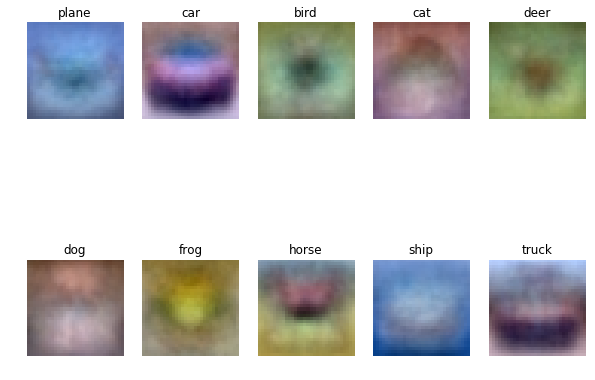

In [112]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])